# Descripción del ejercicio

En el contexto del *Marketplace* de **Mercado Libre**, se requiere un algoritmo de *Machine Learning* que permita **predecir si un artículo listado es nuevo o usado**.

## Objetivo

Diseñar, entrenar y evaluar un modelo de clasificación binaria que determine la condición del artículo (nuevo vs usado) utilizando datos estructurados disponibles en el archivo `MLA_100k.jsonlines`.

## Recursos proporcionados

- Un conjunto de datos en formato `.jsonlines` (`MLA_100k.jsonlines`) con información de publicaciones de productos.
- Una función auxiliar llamada `build_dataset` para la lectura y construcción del *dataset*.

## Requisitos de la tarea

- Preprocesar y analizar los datos.
- Entrenar un modelo de clasificación supervisada.
- Evaluar el rendimiento del modelo utilizando una **métrica adecuada**.
- Justificar la elección de dicha métrica de evaluación.

## Entregables

- Un archivo `.ipynb` que incluya: 
  - El **flujo de procesamiento**, desde la lectura de los datos hasta la evaluación final del modelo.
  - Una **explicación breve sobre la métrica de evaluación elegida**.
  - El **resultado alcanzado** por el modelo usando esa métrica.

## Consideraciones

Para este proyecto estoy usando Python 3.12.2 


# Separación de conjunto de train y test

In [2]:
# Importo las librerias que estaré utilizando 
import pandas as pd
import numpy as np
import json

import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score


In [3]:
pd.options.display.max_columns=None

Uso la función build_dataset() contenida en new_or_used.py

In [6]:
def build_dataset():
    data = [json.loads(x) for x in open("../data/MLA_100k.jsonlines")]
    target = lambda x: x.get("condition")
    N = -10000
    X_train = data[:N]
    X_test = data[N:]
    y_train = [target(x) for x in X_train]
    y_test = [target(x) for x in X_test]
    for x in X_test:
        del x["condition"]
    return X_train, y_train, X_test, y_test

In [7]:
X_train, y_train, X_test, y_test = build_dataset()

# Exploración de los datos (EDA)

La primero que hare será extraer la información de las columnas que aun estan en formato json

In [8]:
# Convertir X_train a DataFrame
df_train = pd.DataFrame(X_train)

# Agregar la columna de etiquetas
df_train["condition"] = y_train

# 1. seller_address - extraer ciudad, estado y país
df_train['state_name'] = df_train['seller_address'].apply(lambda x: x.get('state', {}).get('name'))
df_train['city_name'] = df_train['seller_address'].apply(lambda x: x.get('city', {}).get('name'))
df_train['country'] = df_train['seller_address'].apply(lambda x: x.get('country', {}).get('name'))

# 2. shipping - extraer si tiene envío gratis y si permite retiro local
df_train['free_shipping'] = df_train['shipping'].apply(lambda x: x.get('free_shipping'))
df_train['local_pick_up'] = df_train['shipping'].apply(lambda x: x.get('local_pick_up'))

# 3. non_mercado_pago_payment_methods - número de métodos distintos
df_train['num_payment_methods'] = df_train['non_mercado_pago_payment_methods'].apply(len)

# 4. descriptions - tiene descripción o no
df_train['has_description'] = df_train['descriptions'].apply(lambda x: len(x) > 0)

# 5. pictures - cuántas imágenes tiene
df_train['num_pictures'] = df_train['pictures'].apply(len)

# 6. geolocation - lat y lon
df_train['latitude'] = df_train['geolocation'].apply(lambda x: x.get('latitude'))
df_train['longitude'] = df_train['geolocation'].apply(lambda x: x.get('longitude'))

# 7. variaciones
df_train["num_variations"] = df_train["variations"].apply(len)
df_train["has_variations"] = df_train["num_variations"] > 0

# 8. atributos clave desde la columna attributes
def extract_value(attr_list, key):
    for att in attr_list:
        if att.get("name") == key:
            return att.get("value_name")
    return None

df_train["gender"] = df_train["attributes"].apply(lambda x: extract_value(x, "Género"))
df_train["season"] = df_train["attributes"].apply(lambda x: extract_value(x, "Season"))
df_train["brand"] = df_train["attributes"].apply(lambda x: extract_value(x, "Marca"))
df_train["color"] = df_train["attributes"].apply(lambda x: extract_value(x, "Color"))
df_train["model"] = df_train["attributes"].apply(lambda x: extract_value(x, "Modelo"))
df_train["main_material"] = df_train["attributes"].apply(lambda x: extract_value(x, "Material principal"))

# 9. Codificar condición como variable binaria
df_train["condition"] = df_train["condition"].apply(lambda x: 1 if x == "new" else 0)

# 10. Aplanar sub_status
df_train['sub_status'] = df_train['sub_status'].apply(
    lambda x: '_'.join(x) if isinstance(x, list) and len(x) > 0 else 'sin_substatus'
)

# 11. Aplanar deal_ids
df_train['deal_ids'] = df_train['deal_ids'].apply(
    lambda x: '_'.join(x) if isinstance(x, list) and len(x) > 0 else 'sin_deal_ids'
)

# 12. tags
df_train['tags'] = df_train['tags'].apply(
    lambda x: '_'.join(x) if isinstance(x, list) and len(x) > 0 else 'sin_tag'
)

# 13. date_created
df_train['date_created'] = pd.to_datetime(df_train['date_created'])

# Crear nuevas columnas
df_train['created_hour'] = df_train['date_created'].dt.hour
df_train['created_weekday'] = df_train['date_created'].dt.dayofweek   # 0 = lunes

# Elimino columnas anidadas originales
df_train = df_train.drop(columns=[
    'seller_address',
    'shipping',
    'non_mercado_pago_payment_methods',
    'descriptions',
    'pictures',
    'geolocation',
    'attributes',
    'variations'
])


Visualizo al conjunto de datos para ver si todas las columnas ya tienen un formato adecuado para su uso en el modelo.

In [9]:
df_train.head(10)

,warranty,sub_status,condition,seller_contact,deal_ids,base_price,seller_id,location,site_id,listing_type_id,price,buying_mode,tags,listing_source,parent_item_id,coverage_areas,category_id,last_updated,international_delivery_mode,id,official_store_id,differential_pricing,accepts_mercadopago,original_price,currency_id,thumbnail,title,automatic_relist,date_created,secure_thumbnail,stop_time,status,video_id,catalog_product_id,subtitle,initial_quantity,start_time,permalink,sold_quantity,available_quantity,state_name,city_name,country,free_shipping,local_pick_up,num_payment_methods,has_description,num_pictures,latitude,longitude,num_variations,has_variations,gender,season,brand,color,model,main_material,created_hour,created_weekday
0,None,sin_substatus,1,None,sin_deal_ids,80.0,74952096,{},MLA,bronze,80.0,buy_it_now,dragged_bids_and_visits,,MLA568261029,[],MLA126406,2015-09-05T20:42:58.000Z,none,MLA578052519,NaN,None,True,NaN,ARS,http://mla-s1-p.mlstatic.com/5386-MLA435206787...,Auriculares Samsung Originales Manos Libres Ca...,False,2015-09-05 20:42:53+00:00,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,2015-11-04T20:42:53.000Z,active,None,NaN,None,1,2015-09-05T20:42:53.000Z,http://articulo.mercadolibre.com.ar/MLA-578052...,0,1,Capital Federal,San Cristóbal,Argentina,False,True,3,True,2,-34.62807,-58.398671,0,False,None,None,None,None,None,None,20,5
1,NUESTRA REPUTACION,sin_substatus,0,None,sin_deal_ids,2650.0,42093335,{},MLA,silver,2650.0,buy_it_now,sin_tag,,MLA561574487,[],MLA10267,2015-09-26T18:08:34.000Z,none,MLA581565358,NaN,None,True,NaN,ARS,http://mla-s1-p.mlstatic.com/23223-MLA20245018...,Cuchillo Daga Acero Carbón Casco Yelmo Solinge...,False,2015-09-26 18:08:30+00:00,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,2015-11-25T18:08:30.000Z,active,None,NaN,None,1,2015-09-26T18:08:30.000Z,http://articulo.mercadolibre.com.ar/MLA-581565...,0,1,Capital Federal,Buenos Aires,Argentina,False,True,2,True,6,-34.593552,-58.505917,0,False,None,None,None,None,None,None,18,5
2,None,sin_substatus,0,None,sin_deal_ids,60.0,133384258,{},MLA,bronze,60.0,buy_it_now,dragged_bids_and_visits,,MLA568881256,[],MLA1227,2015-09-09T23:57:10.000Z,none,MLA578780872,NaN,None,True,NaN,ARS,http://mla-s1-p.mlstatic.com/22076-MLA20223367...,"Antigua Revista Billiken, N° 1826, Año 1954",False,2015-09-09 23:57:07+00:00,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,2015-11-08T23:57:07.000Z,active,None,NaN,None,1,2015-09-09T23:57:07.000Z,http://articulo.mercadolibre.com.ar/MLA-578780...,0,1,Capital Federal,Boedo,Argentina,False,True,3,True,1,-34.623391,-58.414395,0,False,None,None,None,None,None,None,23,2
3,None,sin_substatus,1,None,sin_deal_ids,580.0,143001605,{},MLA,silver,580.0,buy_it_now,sin_tag,,None,[],MLA86345,2015-10-05T16:03:50.306Z,none,MLA581877385,NaN,None,True,NaN,ARS,http://mla-s2-p.mlstatic.com/183901-MLA2043288...,Alarma Guardtex Gx412 Seguridad Para El Automo...,False,2015-09-28 18:47:56+00:00,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,2015-12-04T01:13:16.000Z,active,None,NaN,None,1,2015-09-28T18:47:56.000Z,http://articulo.mercadolibre.com.ar/MLA-581877...,0,1,Capital Federal,Floresta,Argentina,False,True,3,True,2,-34.628189,-58.492921,0,False,None,None,None,None,None,None,18,0
4,MI REPUTACION.,sin_substatus,0,None,sin_deal_ids,30.0,96873449,{},MLA,bronze,30.0,buy_it_now,dragged_bids_and_visits,,MLA566354576,[],MLA41287,2015-08-28T13:37:41.000Z,none,MLA576112692,NaN,None,True,NaN,ARS,http://mla-s2-p.mlstatic.com/13595-MLA13041807...,Serenata - Jennifer Blake,False,2015-08-24 22:07:20+00:00,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,2015-10-23T22:07:20.000Z,active,None,NaN,None,1,2015-08-24T22:07:20.000Z,http://articulo.mercadolibre.com.ar/MLA-576112...,0,1,Buenos Aires,Tres de febrero,Argentina,False,True,3,True,2,-34.634655,-58.549504,0,False,None,None,None,None,None,None,22,0
5,Sí,sin_substatus,1,None,sin_deal_ids,310.0,93122911,{},MLA,bronze,310.0,buy_it_now,dragged_bids_and_visits,,MLA562683364,[],MLA1429,2015-08-30T

Doy una primer lectura rapida al total de columnas y variables con valores nulos.

In [111]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 58 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   warranty                     35243 non-null  object 
 1   sub_status                   90000 non-null  object 
 2   condition                    90000 non-null  int64  
 3   seller_contact               1982 non-null   object 
 4   deal_ids                     90000 non-null  object 
 5   base_price                   90000 non-null  float64
 6   seller_id                    90000 non-null  int64  
 7   location                     90000 non-null  object 
 8   site_id                      90000 non-null  object 
 9   listing_type_id              90000 non-null  object 
 10  price                        90000 non-null  float64
 11  buying_mode                  90000 non-null  object 
 12  tags                         90000 non-null  object 
 13  listing_source  

## Funciones a utilizar para el análisis de variables

La siguiente función tiene como objetivo identificar las palabras más frecuentes en una columna de texto de un DataFrame, excluyendo aquellas que no aportan valor analítico (stopwords).

Mi idea es utilizarla para:

  - Identificar los términos dominantes en las variables de garantia, titulo, etc.
  - Apoyar tareas de ingeniería de variables o análisis exploratorio.

Esta función realiza lo siguiente:

1. **Elimina valores nulos** y convierte todo a minúsculas.
2. **Limpia el texto** para quedarse solo con palabras alfabéticas (omitiendo símbolos o números).
3. **Filtra las stopwords** (como “el”, “la”, “de”, etc.) que no agregan significado.
4. **Cuenta la frecuencia** de las palabras restantes.
5. **Devuelve el top N** de palabras más comunes en la columna.

In [11]:
import nltk
nltk.download('stopwords')

from collections import Counter
import re
from nltk.corpus import stopwords

def top_words_from_column(df, column, top_n=20, language='spanish'):
    """
    Devuelve las N palabras más comunes en una columna de texto, excluyendo stopwords.
    """
    # Obtener lista de stopwords en español
    stop_words = set(stopwords.words(language))
    
    # Unir texto y limpiar
    text = ' '.join(df[column].dropna().astype(str).str.lower())
    words = re.findall(r'\b\w+\b', text)
    
    # Filtrar stopwords
    filtered_words = [word for word in words if word not in stop_words]
    
    word_counts = Counter(filtered_words)
    return word_counts.most_common(top_n)



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/omargarciaflores/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


La siguiente función permite analizar cómo se distribuye la variable objetivo (`condition`, que indica si un artículo es **nuevo** o **usado**) a través de los niveles de una variable categórica.

Al analizar una variable categórica (por ejemplo, `has_warranty`, `listing_type`, etc.), es importante saber:

- Cuántos registros hay por cada categoría (`count`).
- Qué proporción de artículos **nuevos** hay dentro de cada categoría (`proportion_new`).
- Qué tan representativa es cada categoría dentro del total (`population_share`).

Este análisis ayuda a:

- Detectar variables con buen poder de discriminación.
- Identificar sesgos o clases dominantes en ciertos subgrupos.
- Guiar decisiones de codificación o agrupación de categorías.

Esta función realiza lo siguiente:

1. **Agrupa** el DataFrame por la columna categórica elegida.
2. Calcula:
   - `count`: cantidad de registros por categoría.
   - `proportion_new`: proporción promedio de artículos nuevos (asumiendo que `condition = 1` si es nuevo).
3. Calcula `population_share`: qué porcentaje del total representa cada categoría.
4. **Imprime** la tabla resumen para inspección.


In [12]:
def porcentaje_clases(df, column):

    warranty_stats = df.groupby(column)['condition'].agg(
        count='size',
        proportion_new='mean',
    ).reset_index()
    
    total_count = warranty_stats['count'].sum()
    warranty_stats['population_share'] = warranty_stats['count'] / total_count
    
    print(warranty_stats)


In [13]:
def porcentaje_clases_2(df, col):
    grupo = df.groupby(col)['condition'].agg(
        count='size',
        proportion_new='mean'
    ).reset_index()
    grupo['population_share'] = grupo['count'] / grupo['count'].sum()
    return grupo


## Porcentaje de las clases

Es importante ver cual es el porcentaje de cada una de las clases entre articulos nuevos y usados para saber si debemos dar algún tratamiento de balanceo de clases.

In [14]:
# porcentaje de cada una de las clases
df_train['condition'].value_counts(normalize=True)


condition
1    0.537244
0    0.462756
Name: proportion, dtype: float64

Podemos ver que no hay un desbalanceo de clases; ahora ire explorando cada variable para ver el tratamiento que debo aplicar.

## Análisis de variables

### 1. warranty

In [15]:
# 1. warranty
top_50_warranty = top_words_from_column(df_train, 'warranty', top_n=50)

for word, freq in top_50_warranty:
    print(f'{word}: {freq}')


garantía: 8843
garantia: 4591
meses: 4404
6: 2614
si: 2375
producto: 2363
calificaciones: 2173
productos: 1529
año: 1377
1: 1323
años: 1275
100: 1236
oficial: 1137
3: 1115
defectos: 1099
fallas: 1027
fabrica: 1023
fabricación: 1021
fabricacion: 843
fabricante: 778
entrega: 744
calidad: 731
libro: 728
compra: 703
comprador: 681
reputacion: 670
12: 663
dias: 663
articulo: 637
falla: 633
total: 623
original: 615
reputación: 612
mejor: 594
caso: 586
solo: 572
nuevo: 567
defecto: 520
libros: 519
cambio: 495
buen: 487
mas: 464
retirar: 463
positivas: 459
uso: 439
originales: 430
factura: 428
condiciones: 427
cualquier: 424
escrita: 414


Una vez que pude ver el top 50 de palabras que vienen en garantía me parece que puedo realizar una función con el objetivo de **inferir si una publicación menciona o sugiere que ofrece garantía**, a partir del análisis del texto contenido en la columna `warranty` y si la ofrece entonces pareciera más probable que el producto pueda ser nuevo.

La función `clasificar_garantia` realiza lo siguiente:

1. **Casos vacíos o en blanco**:
   - Si el valor es `NaN` o está vacío, se considera como **sin información de garantía** retorna `0`.

2. **Frases negativas explícitas**:
   - Si encuentra expresiones como `"no"`, `"sin"`, `"ninguna"`, `"no tiene"`, `"no hay"`, se interpreta como que **no tiene garantía** retorna `0`.

3. **Palabras que sugieren garantía**:
   - Si el texto contiene términos como `"garantía"`, `"producto"`, `"fabricante"`, `"falla"`, `"original"`, `"entrega"`, `"meses"`, etc., se considera **relacionado con garantía** retorna `1`.

4. **Caso neutro**:
   - Si no hay ninguna pista clara, se considera como **no garantía explícita** retorna `0`.


In [32]:
import re

def clasificar_garantia(x):
    if pd.isna(x) or str(x).strip() == '':
        return 0  # Sin información

    x_str = str(x).lower()
    
    # Expresiones que indican que NO tiene garantía
    if re.search(r'\b(no|sin|ninguna|no tiene|no hay)\b', x_str):
        return 0
    
    # Palabras que sugieren garantía (sin afirmarlo directamente)
    posibles = [
        "garantía","garantia",
        "si", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", 
        "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24",
        "dias", "dia", "mes", "articulo", "articulos", "original", "originales",
        "meses", "producto", "productos", "calificaciones", "oficial", "defecto"
        "defectos", "fabricación", "fabricacion" "fabrica", "fabricante", "falla", "fallas", "entrega",
        "compra", "comprador", "calidad", "año", "años", "libro", "garantizado", "garantiza",

    ]
    
    if any(palabra in x_str for palabra in posibles):
        return 1  # Texto relacionado a garantía

    return 0  # Garantía afirmada o no negada explícitamente

df_train['has_warranty'] = df_train['warranty'].apply(clasificar_garantia)


In [95]:
_ = porcentaje_clases(df_train, 'has_warranty')


   has_warranty  count  proportion_new  population_share
0             0  70697        0.478111          0.785522
1             1  19303        0.753821          0.214478


Podemos concluir que la tranformación realizada a la variable warranty fue exitosa ya que:

* Gracias a la extracción de palabras clave en la garantía que nos sugieran que el producto puede ser nuevo encontramos un grupo que corresponde al 21% de la población de los cuales 75% corresponden a producto nuevo
* Agrupamiento de los segmentos con palabras que sugerian no garantia y segmento vacio

### 2. sub_status

In [105]:
df_train['sub_status'].unique()


array(['sin_substatus', 'suspended', 'expired', 'deleted'], dtype=object)

In [106]:
_ = porcentaje_clases(df_train, 'sub_status')

      sub_status  count  proportion_new  population_share
0        deleted      7        0.571429          0.000078
1        expired     13        0.384615          0.000144
2  sin_substatus  89109        0.537084          0.990100
3      suspended    871        0.555683          0.009678


En substatus parece que no hay nada que hacer porque todo se concentra en "sin_substatus", es decir, la variable es mayormente nula

### 3. seller_contact

In [17]:
# Crear variable binaria
df_train['has_seller_contact'] = df_train['seller_contact'].apply(
    lambda x: int(pd.notna(x) and isinstance(x, dict) and len(x) > 0)
)

_ = porcentaje_clases(df_train, 'has_seller_contact')


   has_seller_contact  count  proportion_new  population_share
0                   0  88018        0.544173          0.977978
1                   1   1982        0.229566          0.022022


Esta variable si tiene grupos diferentes en cuanto a la proporción de articulos nuevos pero el porcentaje de la población que es diferente al promedio es muy bajo, aún asi la probaremos.

### 4. buying_mode

In [123]:
df_train['buying_mode'].unique()

array(['buy_it_now', 'classified', 'auction'], dtype=object)

In [124]:
_ = porcentaje_clases(df_train, 'buying_mode')

  buying_mode  count  proportion_new  population_share
0     auction    707        0.322489          0.007856
1  buy_it_now  87311        0.545968          0.970122
2  classified   1982        0.229566          0.022022


Esta variable es similar a la de arriba, por lo que tomaré esta variable clasificando de manera binaria buy_it_now = 1 y sino 0.

### 5. Price

In [125]:
# Crear deciles de precio: 1 (más bajo) a 10 (más alto)
df_train['price_decile'] = pd.qcut(df_train['price'], q=10, labels=False) + 1


In [126]:
_ = porcentaje_clases(df_train, 'price_decile')

   price_decile  count  proportion_new  population_share
0             1   9147        0.408003          0.101633
1             2   8858        0.271506          0.098422
2             3   9016        0.403949          0.100178
3             4   9138        0.507879          0.101533
4             5  10110        0.577151          0.112333
5             6   7746        0.645882          0.086067
6             7   9455        0.651719          0.105056
7             8   8571        0.704585          0.095233
8             9   8962        0.673064          0.099578
9            10   8997        0.540291          0.099967


Parece que entre más alto es el precio mayor probabilidad de que el articulo sea nuevo a excepción del ultimo decil que podría corresponder a autos talvez, dejare la variable sin tranformación de momento.

### 6. listing_type_id

In [131]:
df_train['listing_type_id'].value_counts()


listing_type_id
bronze          56904
free            19260
silver           8195
gold_special     2693
gold             2170
gold_premium      765
gold_pro           13
Name: count, dtype: int64

In [132]:
_ = porcentaje_clases(df_train, 'listing_type_id')

  listing_type_id  count  proportion_new  population_share
0          bronze  56904        0.622276          0.632267
1            free  19260        0.074143          0.214000
2            gold   2170        0.861290          0.024111
3    gold_premium    765        0.543791          0.008500
4        gold_pro     13        1.000000          0.000144
5    gold_special   2693        0.980691          0.029922
6          silver   8195        0.802318          0.091056


Esta variable ayudará mucho al modelo ya que tiene grupos muy diferentes, con los cuales crearé 3 categorias

* gold: gold, gold_premium, gold_pro, gold_special, silver
* bronze: bronze, gold_premium
* free: free

La idea detras de esto es juntar a las categorias que tienen porcentajes similares de productos nuevos

### 7. tags

In [135]:
df_train['tags'].value_counts()

tags
dragged_bids_and_visits                           65315
sin_tag                                           22412
good_quality_thumbnail_dragged_bids_and_visits     1191
dragged_visits                                      464
good_quality_thumbnail                              346
dragged_visits_free_relist                          259
poor_quality_thumbnail_dragged_bids_and_visits       10
poor_quality_thumbnail                                3
Name: count, dtype: int64

In [136]:
_ = porcentaje_clases(df_train, 'tags')

                                             tags  count  proportion_new  \
0                         dragged_bids_and_visits  65315        0.529388   
1                                  dragged_visits    464        0.368534   
2                      dragged_visits_free_relist    259        0.038610   
3                          good_quality_thumbnail    346        0.794798   
4  good_quality_thumbnail_dragged_bids_and_visits   1191        0.913518   
5                          poor_quality_thumbnail      3        1.000000   
6  poor_quality_thumbnail_dragged_bids_and_visits     10        1.000000   
7                                         sin_tag  22412        0.545154   

   population_share  
0          0.725722  
1          0.005156  
2          0.002878  
3          0.003844  
4          0.013233  
5          0.000033  
6          0.000111  
7          0.249022  


Realizo variable binaria agrupando 'good_quality_thumbnail_dragged_bids_and_visits' y 'good_quality_thumbnail'

### 8. category_id

In [141]:
df_train['category_id'].value_counts()

category_id
MLA1227      4139
MLA2044      1759
MLA41287      829
MLA3530       685
MLA2038       601
             ... 
MLA376520       1
MLA32782        1
MLA96545        1
MLA100025       1
MLA7212         1
Name: count, Length: 10491, dtype: int64

In [35]:
categorias = porcentaje_clases_2(df_train, 'category_id')

Al tener tantas categorias quiero centrarme en identificar aquellas categorías (`category_id`) donde:

1. Se tiene un número **mínimo de observaciones** (al menos 10 publicaciones), y
2. **La gran mayoría de los artículos son nuevos** (≥ 75%).

Estas categorías serán marcadas como "altas" para su posterior uso como variable predictora (`categoria`).

In [36]:
categorias_altas = categorias[
    (categorias['count'] >= 10) & 
    (categorias['proportion_new'] >= 0.75)
]

# Obtener solo los IDs
categorias_id_altas = set(categorias_altas['category_id'])



In [159]:
df_train['categoria_agrupada'] = df_train['category_id'].apply(
    lambda x: 1 if x in categorias_id_altas else 0
)


In [161]:
_ = porcentaje_clases(df_train, 'categoria_agrupada')

   categoria_agrupada  count  proportion_new  population_share
0                   0  69092        0.420439          0.767689
1                   1  20908        0.923235          0.232311


La conclusión es que este tratamiento funcionó de buena manera ya que ahora tenemos un grupo que representa al 23.2% de la población donde el 92.3% de los articulos son nuevos.

### 9. date_created

A partir de date_created realizo

* created_weekday
* created_hour
  
Mi idea es que si una publicación se realiza de lunes a viernes en un horario laboral es más probable que esa publicación sea de un articulo nuevo.

In [205]:
_ = porcentaje_clases(df_train, 'created_weekday')

   created_weekday  count  proportion_new  population_share
0                0  16098        0.550627          0.178867
1                1  16857        0.564395          0.187300
2                2  14264        0.547042          0.158489
3                3  11294        0.522224          0.125489
4                4  13123        0.557190          0.145811
5                5   9535        0.504143          0.105944
6                6   8829        0.470495          0.098100


Inicialmente la idea parece correcta en cierto nivel, ya que la probabilidad baja en sabado y domingo.

In [206]:
_ = porcentaje_clases(df_train, 'created_hour')

    created_hour  count  proportion_new  population_share
0              0   4236        0.467186          0.047067
1              1   3966        0.466213          0.044067
2              2   3662        0.519934          0.040689
3              3   2611        0.507468          0.029011
4              4   1521        0.488494          0.016900
5              5    909        0.470847          0.010100
6              6    479        0.563674          0.005322
7              7    401        0.596010          0.004456
8              8    357        0.487395          0.003967
9              9    568        0.424296          0.006311
10            10   1406        0.465149          0.015622
11            11   2958        0.580122          0.032867
12            12   4959        0.597701          0.055100
13            13   6018        0.589398          0.066867
14            14   6551        0.584796          0.072789
15            15   6304        0.559169          0.070044
16            

El objetivo es evaluar si el **momento de publicación** de un artículo (día y hora) influye en la probabilidad de que el artículo sea **nuevo** o **usado**, por lo que crearé una función para dividir el día en dos bloques horarios y ver si puedo encontrar una agrupación que pueda usar.

In [31]:
def categorizar_hora(h):
    if 11 <= h <= 20:
        return 'hora_alta'
    else:
        return 'hora_baja'

df_train['hour_block'] = df_train['created_hour'].apply(categorizar_hora)
df_train['weekday_block'] = df_train['created_weekday'].astype(str) + '_' + df_train['hour_block']


In [19]:
_ = porcentaje_clases(df_train, 'weekday_block')

   weekday_block  count  proportion_new  population_share
0    0_hora_alta   9790        0.573136          0.108778
1    0_hora_baja   6308        0.515694          0.070089
2    1_hora_alta  10920        0.595055          0.121333
3    1_hora_baja   5937        0.508001          0.065967
4    2_hora_alta   8488        0.573751          0.094311
5    2_hora_baja   5776        0.507791          0.064178
6    3_hora_alta   6272        0.555963          0.069689
7    3_hora_baja   5022        0.480088          0.055800
8    4_hora_alta   8577        0.606039          0.095300
9    4_hora_baja   4546        0.465024          0.050511
10   5_hora_alta   5527        0.535734          0.061411
11   5_hora_baja   4008        0.460579          0.044533
12   6_hora_alta   4671        0.472490          0.051900
13   6_hora_baja   4158        0.468254          0.046200


Crearé una variable binaria donde agrupe:
* Hora alta de lunes a sabado (mayor porcentaje de venta de articulos nuevos)
* Resto de categorias

In [20]:
# Variable binaria: 1 si es hora alta de lunes a sábado, 0 en otro caso
df_train['horario_de_creacion'] = df_train.apply(
    lambda row: 1 if int(row['created_weekday']) in range(6) and row['hour_block'] == 'hora_alta' else 0,
    axis=1
)


In [21]:
_ = porcentaje_clases(df_train, 'horario_de_creacion')

   horario_de_creacion  count  proportion_new  population_share
0                    0  40426        0.487978          0.449178
1                    1  49574        0.577420          0.550822


Podemos notar una separación del porcentaje de articulos nuevos en ambos grupos.

### 10. official_store_id

In [242]:
df_train['official_store_id'].unique()

array([ nan, 322., 308., 216., 170., 128.,  20., 309., 365., 157.,   9.,
       296., 256.,   4., 221., 325., 197., 158., 371.,  38., 269.,  46.,
       190.,  57., 272., 273., 350., 444., 174.,  23.,  18.,  70., 121.,
       148., 130., 409., 114.,  32., 165.,  44.,  16., 152., 264., 344.,
        47.,   3., 382., 262., 446., 252., 176.,   5., 280.,  49., 279.,
       321., 211., 420., 304., 329., 107.,  25., 138.,  66.,   1.,  84.,
       251., 140., 429., 372.,  67., 368., 398., 259., 236., 238., 285.,
       213., 106.,  40., 313., 413., 373., 357., 223., 224., 185.,  11.,
       290., 311., 393., 191.,  55., 208., 115.,  42., 358., 242.,  82.,
        80.,  87., 392., 306., 395., 255., 302., 333., 229., 109., 189.,
       332., 406.,  72., 245., 284., 305.,  31., 315.,  52., 162., 198.,
       389., 200.,  71., 171.,  34., 265., 147., 268., 367., 168.,  41.,
       241., 388., 312., 423., 131., 196.,  21., 110., 364., 244., 403.,
       431., 113., 132.,  17.,  77.,  30., 289., 26

In [243]:
df_train['has_official_store'] = df_train['official_store_id'].apply(
    lambda x: 1 if pd.notna(x) else 0
)

In [244]:
_ = porcentaje_clases(df_train, 'has_official_store')

   has_official_store  count  proportion_new  population_share
0                   0  89255        0.533617          0.991722
1                   1    745        0.971812          0.008278


A pesar de que son pocos registros parece que cuando un producto viene de una tienda oficial es muy probable que sea nuevo.

### 11. accepts_mercadopago

In [249]:
df_train['accepts_mercadopago'].unique()

array([ True, False])

In [250]:
_ = porcentaje_clases(df_train, 'accepts_mercadopago')

   accepts_mercadopago  count  proportion_new  population_share
0                False   1982        0.229566          0.022022
1                 True  88018        0.544173          0.977978


Si no se acepta mercadopago es más probable que el producto no sea nuevo, aunque es poca población.

### 12. original_price

In [254]:
df_train['diff_price'] = df_train['original_price'] - df_train['price']

In [255]:
df_train['has_diff_price'] = df_train['diff_price'].apply(lambda x: 1 if x > 0 else 0)

In [256]:
_ = porcentaje_clases(df_train, 'has_diff_price')

   has_diff_price  count  proportion_new  population_share
0               0  89873        0.536591          0.998589
1               1    127        1.000000          0.001411


Dejare esta variable afuera porque no hace mucho sentido y los registros son pocos.

### 13. currency_id

In [257]:
df_train['currency_id'].unique()

array(['ARS', 'USD'], dtype=object)

In [258]:
_ = porcentaje_clases(df_train, 'currency_id')

  currency_id  count  proportion_new  population_share
0         ARS  89496        0.538180            0.9944
1         USD    504        0.371032            0.0056


No incluiré esta variable

### 14. title

Con esta variable realizaré algo muy similar al tratamiento que le di a warranty.

In [261]:
top_50_title = top_words_from_column(df_train, 'title', top_n=50)

for word, freq in top_50_title:
    print(f'{word}: {freq}')

2: 4462
1: 4358
original: 3055
x: 2986
nuevo: 2908
3: 2580
4: 2206
cd: 2035
5: 1864
libro: 1626
vinilo: 1580
c: 1579
6: 1577
the: 1563
s: 1394
talle: 1357
kit: 1275
10: 1162
antiguo: 1160
lote: 1101
revista: 1087
antigua: 1048
argentina: 1038
p: 1038
juego: 1017
digital: 1009
m: 981
samsung: 945
100: 929
12: 918
lp: 916
cuero: 910
ed: 906
8: 899
caja: 895
dvd: 892
n: 883
ford: 878
0: 862
excelente: 848
año: 834
mujer: 829
cm: 821
oferta: 811
disco: 801
fiat: 795
mesa: 793
50: 761
madera: 750
nueva: 736


El objetivo es identificar si el **título del producto** sugiere que el artículo es **usado**, **nuevo** o si no hay evidencia suficiente para determinarlo.

La función `clasificar_titulo` evalúa el texto en tres niveles:

1. **Texto vacío, nulo, no concluyente** se asigna clase `0`.
2. Si el título contiene palabras que **sugieren que NO es nuevo**  
   como `"usado"`, `"segunda mano"`, `"reacondicionado"`, etc.  
   se asigna clase `1` (indicación de que es **usado**).
3. Si el título contiene palabras que **sugieren que es nuevo**  
   como `"nuevo"`, `"original"`, `"kit"`, `"caja"`, `"oferta"` o números típicos de meses de garantía (`"12"`, `"24"`, etc.)  
   se asigna clase `2` (indicación de que es **nuevo**).


In [30]:
import re

def clasificar_titulo(x):
    if pd.isna(x) or str(x).strip() == '':
        return 0  # Sin información

    x_str = str(x).lower()
    
    # Expresiones que indican que NO es nuevo
    if re.search(r'\b(antiguo|antigua|usado|usada|usados|usadas|segunda mano|reacondicionado|reacondicionada|reacondicionados|desgaste|funciona|funcional)\b', x_str):
        return 1
    
    # Palabras que sugieren que es nuevo
    posibles = [
        "nuevo","nueva","nuevos","nuevas","original","originales","kit", "caja",
        "oferta",
        "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", 
        "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24",
        "50","100"
    ]
    
    if any(palabra in x_str for palabra in posibles):
        return 2  

    return 0  

df_train['title_class'] = df_train['title'].apply(clasificar_titulo)


In [304]:
_ = porcentaje_clases(df_train, 'title_class')

   title_class  count  proportion_new  population_share
0            0  39203        0.446037          0.435589
1            1   3032        0.072559          0.033689
2            2  47765        0.641599          0.530722


Realizare variables dummy para la categoria 1 y 2

### 15 .automatic_relist

In [313]:
df_train['automatic_relist'].value_counts()

automatic_relist
False    85773
True      4227
Name: count, dtype: int64

In [314]:
_ = porcentaje_clases(df_train, 'automatic_relist')

   automatic_relist  count  proportion_new  population_share
0             False  85773        0.516631          0.953033
1              True   4227        0.955524          0.046967


Parece muy claro que cuando un articulo se republica es muy probable que sean articulos nuevos. 

### 16. status

In [319]:
df_train['status'].value_counts()

status
active            86116
paused             3863
closed               20
not_yet_active        1
Name: count, dtype: int64

In [320]:
_ = porcentaje_clases(df_train, 'status')

           status  count  proportion_new  population_share
0          active  86116        0.530819          0.956844
1          closed     20        0.450000          0.000222
2  not_yet_active      1        1.000000          0.000011
3          paused   3863        0.680818          0.042922


Aqui hace sentido que 'paused' tenga mayor proporción de articulos nuevos ya que puede que el status esta pausado por un tema de stock, haré esta variable binaria.

### 17. available_quantity

In [22]:
_ = porcentaje_clases(df_train, 'available_quantity')

     available_quantity  count  proportion_new  population_share
0                     1  63732        0.367288          0.708133
1                     2   4737        0.884315          0.052633
2                     3   3184        0.942839          0.035378
3                     4   1801        0.938923          0.020011
4                     5   2052        0.962963          0.022800
..                  ...    ...             ...               ...
436                9995      2        1.000000          0.000022
437                9996      6        1.000000          0.000067
438                9997     12        1.000000          0.000133
439                9998     16        1.000000          0.000178
440                9999     66        0.984848          0.000733

[441 rows x 4 columns]


In [23]:
df_train['disponibilidad_de_stock'] = df_train['available_quantity'].apply(lambda x: 1 if x > 1 else 0)

In [24]:
_ = porcentaje_clases(df_train, 'disponibilidad_de_stock')

   disponibilidad_de_stock  count  proportion_new  population_share
0                        0  63732        0.367288          0.708133
1                        1  26268        0.949596          0.291867


La variable `available_quantity` representa la cantidad de unidades disponibles para un artículo publicado y se observa lo siguiente:

- Cuando `available_quantity = 1`, la proporción de artículos **nuevos** es baja (alrededor del 36%).
- A partir de `available_quantity > 1`, la proporción de artículos **nuevos** aumenta considerablemente (mayor al 88%).

Con base en este análisis, se generó una nueva variable binaria llamada `disponibilidad_de_stock`:


### 18. free_shipping

In [25]:
_ = porcentaje_clases(df_train, 'free_shipping')

   free_shipping  count  proportion_new  population_share
0          False  87303        0.525194          0.970033
1           True   2697        0.927327          0.029967


Incluiré esta variable binaria

### 19. has_description

In [344]:
_ = porcentaje_clases(df_train, 'has_description')

   has_description  count  proportion_new  population_share
0            False   2417        0.424907          0.026856
1             True  87583        0.540345          0.973144


Podriamos incluir esta variable y ver si tiene un efecto positivo en el modelo

### 20. num_pictures

In [345]:
_ = porcentaje_clases(df_train, 'num_pictures')

    num_pictures  count  proportion_new  population_share
0              0    703        0.322902          0.007811
1              1  30018        0.501466          0.333533
2              2  16010        0.534791          0.177889
3              3  13261        0.563758          0.147344
4              4   9294        0.537336          0.103267
5              5   6757        0.531005          0.075078
6              6  12434        0.632218          0.138156
7              7    270        0.422222          0.003000
8              8    197        0.380711          0.002189
9              9    188        0.382979          0.002089
10            10    179        0.407821          0.001989
11            11    117        0.401709          0.001300
12            12    103        0.436893          0.001144
13            13     75        0.293333          0.000833
14            14    307        0.214984          0.003411
15            15     47        0.829787          0.000522
16            

Parece que no podemos sacar una conclusión clara con la variable 'pictures'

### 21. num_variations

In [356]:
_ = porcentaje_clases(df_train, 'num_variations')

    num_variations  count  proportion_new  population_share
0                0  82626        0.533876          0.918067
1                1   5334        0.427072          0.059267
2                2    358        0.863128          0.003978
3                3    235        0.931915          0.002611
4                4    392        0.982143          0.004356
5                5    258        0.992248          0.002867
6                6    222        1.000000          0.002467
7                7    231        0.987013          0.002567
8                8     68        1.000000          0.000756
9                9     31        1.000000          0.000344
10              10     86        0.988372          0.000956
11              11     20        1.000000          0.000222
12              12     42        1.000000          0.000467
13              13      4        1.000000          0.000044
14              14     12        1.000000          0.000133
15              15     11        1.00000

In [363]:
df_train['num_variations_gt_2'] = df_train['num_variations'].apply(lambda x: 1 if x >= 2 else 0)

In [365]:
_ = porcentaje_clases(df_train, 'num_variations_gt_2')

   num_variations_gt_2  count  proportion_new  population_share
0                    0  87960        0.527399          0.977333
1                    1   2040        0.961765          0.022667


Incluiremos 'num_variations_gt_2' para ver si tiene un efecto en el modelo.

# Preprocesado de datos

Aplico el mismo preprocesado de datos que hice arriba pero ahora con la idea de aplicarlo en las poblaciones de train y test.

In [58]:
def preprocesado_datos(X, y):

    # Convertir X_train a DataFrame
    df = pd.DataFrame(X)
    
    # Agregar la columna de etiquetas
    df["condition"] = y
    
    # 1. seller_address - extraer ciudad, estado y país
    df['state_name'] = df['seller_address'].apply(lambda x: x.get('state', {}).get('name'))
    df['city_name'] = df['seller_address'].apply(lambda x: x.get('city', {}).get('name'))
    df['country'] = df['seller_address'].apply(lambda x: x.get('country', {}).get('name'))
    
    # 2. shipping - extraer si tiene envío gratis y si permite retiro local
    df['free_shipping'] = df['shipping'].apply(lambda x: x.get('free_shipping'))
    df['local_pick_up'] = df['shipping'].apply(lambda x: x.get('local_pick_up'))
    
    # 3. non_mercado_pago_payment_methods - número de métodos distintos
    df['num_payment_methods'] = df['non_mercado_pago_payment_methods'].apply(len)
    
    # 4. descriptions - tiene descripción o no
    df['has_description'] = df['descriptions'].apply(lambda x: len(x) > 0)
    
    # 5. pictures - cuántas imágenes tiene
    df['num_pictures'] = df['pictures'].apply(len)
    
    # 6. geolocation - lat y lon
    df['latitude'] = df['geolocation'].apply(lambda x: x.get('latitude'))
    df['longitude'] = df['geolocation'].apply(lambda x: x.get('longitude'))
    
    # 7. variaciones
    df["num_variations"] = df["variations"].apply(len)
    df["has_variations"] = df["num_variations"] > 0
    
    
    # 8. atributos clave desde la columna attributes
    def extract_value(attr_list, key):
        for att in attr_list:
            if att.get("name") == key:
                return att.get("value_name")
        return None
    
    df["gender"] = df["attributes"].apply(lambda x: extract_value(x, "Género"))
    df["season"] = df["attributes"].apply(lambda x: extract_value(x, "Season"))
    df["brand"] = df["attributes"].apply(lambda x: extract_value(x, "Marca"))
    df["color"] = df["attributes"].apply(lambda x: extract_value(x, "Color"))
    df["model"] = df["attributes"].apply(lambda x: extract_value(x, "Modelo"))
    df["main_material"] = df["attributes"].apply(lambda x: extract_value(x, "Material principal"))
    
    
    # 9. Codificar condición como variable binaria
    df["condition"] = df["condition"].apply(lambda x: 1 if x == "new" else 0)
    
    # 10. Aplanar sub_status
    df['sub_status'] = df['sub_status'].apply(
        lambda x: '_'.join(x) if isinstance(x, list) and len(x) > 0 else 'sin_substatus'
    )
    
    # 11. Aplanar deal_ids
    df['deal_ids'] = df['deal_ids'].apply(
        lambda x: '_'.join(x) if isinstance(x, list) and len(x) > 0 else 'sin_deal_ids'
    )
    
    # 12. tags
    df['tags'] = df['tags'].apply(
        lambda x: '_'.join(x) if isinstance(x, list) and len(x) > 0 else 'sin_tag'
    )
    
    # 13. date_created
    df['date_created'] = pd.to_datetime(df['date_created'])

    # Crear nuevas columnas
    df['created_hour'] = df['date_created'].dt.hour
    df['created_weekday'] = df['date_created'].dt.dayofweek   # 0 = lunes


    def categorizar_hora(h):
        if 11 <= h <= 20:
            return 'hora_alta'
        else:
            return 'hora_baja'

    df['hour_block'] = df['created_hour'].apply(categorizar_hora)
    df['weekday_block'] = df['created_weekday'].astype(str) + '_' + df['hour_block']


    # Elimino columnas anidadas originales
    df = df.drop(columns=[
        'seller_address',
        'shipping',
        'non_mercado_pago_payment_methods',
        'descriptions',
        'pictures',
        'geolocation',
        'attributes',
        'variations'
    ])

    return df

In [59]:
train_aux = preprocesado_datos(X_train, y_train)
test_aux = preprocesado_datos(X_test, y_test)

# Ingeniería de variables

Aplico todas las tranformaciones sugeridas basadas en los análisis hechos en la parte del EDA.

In [60]:
def transformacion_datos(df): 

    # 1. warranty
    df['garantia'] = df['warranty'].apply(clasificar_garantia)

    # 2. seller_contact
    df['contacto_vendedor'] = df['seller_contact'].apply(
    lambda x: int(pd.notna(x) and isinstance(x, dict) and len(x) > 0)
    )

    # 3. buying_mode
    df['compra_inmediata'] = df["buying_mode"].apply(lambda x: 1 if x == "buy_it_now" else 0)

    # 4. listing_type_id
    def map_listing_type(listing_type):
        if listing_type in ['gold', 'gold_premium', 'gold_pro', 'gold_special', 'silver']:
            return 'oro'
        elif listing_type in ['bronze']:
            return 'bronce'
        elif listing_type in ['free']:
            return 'gratis'
        else:
            return 'otros'  # Por si aparece alguno inesperado
    
    # Crear nueva columna
    df['listado'] = df['listing_type_id'].apply(map_listing_type)

    # Crear variables dummies y unirlas al dataframe original
    dummies = pd.get_dummies(df['listado'], prefix='listado', dtype=int)

    # Unir al dataframe
    df = pd.concat([df, dummies], axis=1)


    # 5. tags
    df['etiqueta_de_calidad'] = df['tags'].apply(
    lambda x: 1 if isinstance(x, list) and (
        'good_quality_thumbnail' in x or
        'good_quality_thumbnail_dragged_bids_and_visits' in x
    ) else 0
    )
 
    # 6. category_id
    df['categoria_del_producto'] = df['category_id'].apply(
    lambda x: 1 if x in categorias_id_altas else 0
    )  # El conjunto de categorias altas se genero en el EDA

    # 13. date_created: variable binaria 1 si es hora alta de lunes a sábado, 0 en otro caso 
    df['horario_de_creacion'] = df.apply(
        lambda row: 1 if int(row['created_weekday']) in range(6) and row['hour_block'] == 'hora_alta' else 0,
        axis=1
    )
    
    # 14. official_store_id
    df['tienda_oficial'] = df['official_store_id'].apply(
    lambda x: 1 if pd.notna(x) else 0
    )

    # 15. accepts_mercadopago
    df['acepta_mercadopago'] = df['accepts_mercadopago'].astype(int)

    # 16. title_class, esta variable binaria es 1 si el titulo tiene palabras que sugieren que es nuevo, 0 en otro caso
    # clasificar_titulo se genero en el EDA
    df['title_class'] = df['title'].apply(clasificar_titulo)
    df['titulo_nuevo'] = np.where(df['title_class'] == 2, 1, 0)
    df['titulo_usado'] = np.where(df['title_class'] == 1, 1, 0)   

    # 17. automatic_relist
    df['republicacion_automatica'] = df['automatic_relist'].astype(int)

    # 18. status
    df['estatus_pausado'] = (df['status'] == 'paused').astype(int)

    # 19. available_quantity
    df['disponibilidad_de_stock'] = df['available_quantity'].apply(lambda x: 1 if x > 1 else 0)

    # 20. free_shipping
    df['envio_gratis'] = df['free_shipping'].astype(int)

    # 21. has_description
    df['tiene_descripcion'] = df['has_description'].astype(int)

    # 22. num_variations
    df['variaciones'] = df['num_variations'].apply(lambda x: 1 if x >= 2 else 0)

    # drop variables
    df = df.drop(columns=['warranty',
                          'listado',
                          'listing_type_id',
                          'tags',
                          'seller_contact',
                          'sub_status',
                          'deal_ids',	
                          'base_price',
                          'seller_id',
                          'location',
                          'site_id',
                          'listing_source',
                          'parent_item_id',
                          'coverage_areas',
                          'category_id',
                          'last_updated',
                          'international_delivery_mode',
                          'id',
                          'official_store_id',
                          'differential_pricing',
                          'original_price',
                          'currency_id',
                          'thumbnail',
                          'title',
                          'secure_thumbnail',
                          'stop_time',
                          'status',
                          'video_id',
                          'catalog_product_id',
                          'subtitle',
                          'initial_quantity',
                          'start_time',
                          'permalink',
                          'sold_quantity',
                          'available_quantity',
                          'state_name',
                          'city_name',
                          'country',
                          'local_pick_up',
                          'num_payment_methods',
                          'num_pictures',
                          'latitude',
                          'longitude',
                          'num_variations',
                          'has_variations',
                          'gender',
                          'season',
                          'brand',
                          'color',
                          'model',
                          'main_material',
                          'date_created',
                          'created_hour',
                          'created_weekday',
                          'hour_block',
                          'weekday_block',
                          'title_class',
                          'accepts_mercadopago',
                          'automatic_relist',
                          'status',
                          'available_quantity',
                          'free_shipping',
                          'has_description',
                          'buying_mode'
                          ])


    return df



In [61]:
train = transformacion_datos(train_aux)
test = transformacion_datos(test_aux)
train


,condition,price,garantia,contacto_vendedor,compra_inmediata,listado_bronce,listado_gratis,listado_oro,etiqueta_de_calidad,categoria_del_producto,horario_de_creacion,tienda_oficial,acepta_mercadopago,titulo_nuevo,titulo_usado,republicacion_automatica,estatus_pausado,disponibilidad_de_stock,envio_gratis,tiene_descripcion,variaciones
0,1,80.00,0,0,1,1,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0
1,0,2650.00,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0
2,0,60.00,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0
3,1,580.00,0,0,1,0,0,1,0,1,1,0,1,1,0,0,0,0,0,1,0
4,0,30.00,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,0,68.00,0,0,1,1,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0
89996,1,126.00,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0
89997,1,300.00,0,0,1,1,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0
89998,1,696.58,1,0,1,1,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0


# Métrica de evaluación

## Justificación de la métrica para evaluación

En este proyecto el objetivo es clasificar productos como **"nuevos" o "usados"**, **sin que exista una preferencia explícita por alguna de las dos clases**. Entonces nos interesa un modelo que equilibre correctamente los errores de tipo falso positivo y falso negativo, evitando favorecer injustamente una clase sobre otra.

---

### F1-score como métrica de evaluación

El **F1-score** es la **media armónica** entre la **precisión** (qué tan bien predice correctamente la clase positiva) y el **recall** (qué tanto logra encontrar todos los positivos reales). En este caso es útil porque:

- Ambas clases son **igualmente importantes**.
- Deseamos **minimizar ambos tipos de errores** (falsos positivos y falsos negativos).

El F1-score penaliza los modelos que tienen alta precisión pero bajo recall (o viceversa), ayudando a mantener un **rendimiento balanceado**.

---

### Comparación vs AUC-ROC

| Métrica          | Limitación |
|------------------|-----------------------------|
| **AUC-ROC**      | Evalúa la capacidad global de discriminación del modelo, pero no se basa en un umbral específico de clasificación. Es útil para comparar modelos, pero no refleja rendimiento real en decisiones binarias. |

---

### Conclusión

El **F1-score** es la mejor opción para esta tarea porque:

- **Equilibra precisión y recall**.
- Es **más informativo** que usar precisión o recall por separado.
- Es **sensible a los errores en ambas clases**.
- Refleja mejor el comportamiento del modelo **cuando se aplica un umbral de decisión fijo** en producción.


# Creación de modelos

En los siguientes bloques construyo y evalúo modelos de clasificación utilizando el algoritmo `XGBoost`.

- Primero separo las variables predictoras y la variable objetivo tanto para el conjunto de entrenamiento como para el de prueba.
- Defino varios hiperparámetros que serán evaluados mediante Grid Search.
- Entreno el modelo utilizando validación cruzada y selecciono la mejor combinación de hiperparámetros.
- Evalúo el rendimiento del modelo en los datos de prueba utilizando principalmente la métrica `F1-score` pero también revisando `AUC ROC`, `Recall` y `Precisión`

In [71]:
# ------------------------------
# Modelo 1: XGBoost tratando de maximizar F1-score
# ------------------------------

# ------------------------------
# Separar features y target
# ------------------------------
X_train = train.drop(columns=['condition'])
y_train = train['condition']

X_test = test.drop(columns=['condition'])
y_test = test['condition']

# ------------------------------
# Hiperparámetros a ajustar
# ------------------------------
param_grid = {
    'n_estimators': [250, 300],
    'max_depth': [4, 5],
    'learning_rate': [0.12, 0.1],
    'subsample': [0.6, 0.7],
    'colsample_bytree': [0.8, 1],
    #'min_child_weight': [5, 10]
}

# ------------------------------
# Modelo base y búsqueda
# ------------------------------
xgb_model = XGBClassifier(
    eval_metric='logloss',
    random_state=42
)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    #scoring='roc_auc',
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# ------------------------------
# Entrenar con CV y mejores parámetros
# ------------------------------
grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor AUC ROC (CV):", grid_search.best_score_)

# ------------------------------
# Evaluación en test
# ------------------------------
best_model_xgb = grid_search.best_estimator_
y_pred_proba_xgb = best_model_xgb.predict_proba(X_test)[:, 1]
y_pred_label_xgb = best_model_xgb.predict(X_test)  


# Buscar el umbral que maximice F1
thresholds = np.linspace(0.1, 0.9, 100)
f1_scores = [f1_score(y_test, y_pred_proba_xgb > t) for t in thresholds]

# Elegir mejor umbral
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"Mejor umbral: {best_threshold:.2f}")
print(f"Mejor F1-score: {best_f1:.4f}")

# Predicción final con umbral óptimo
y_pred_opt = (y_pred_proba_xgb > best_threshold).astype(int)


auc_test = roc_auc_score(y_test, y_pred_opt)
recall_test = recall_score(y_test, y_pred_opt)
precision_test = precision_score(y_test, y_pred_opt)
f1_test = f1_score(y_test, y_pred_opt)


print(f"AUC ROC en test: {auc_test:.4f}")
print(f"Recall en test: {recall_test:.4f}")
print(f"Precision en test: {precision_test:.4f}")
print(f"F1-score en test: {f1_test:.4f}")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Mejores hiperparámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.12, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.7}
Mejor AUC ROC (CV): 0.8638340986034552
Mejor umbral: 0.41
Mejor F1-score: 0.8674
AUC ROC en test: 0.8530
Recall en test: 0.8774
Precision en test: 0.8577
F1-score en test: 0.8674


In [65]:
# ------------------------------
# Modelo 2: XGBoost tratando de maximizar AUC ROC
# ------------------------------

# ------------------------------
# Separar features y target
# ------------------------------
X_train = train.drop(columns=['condition'])
y_train = train['condition']

X_test = test.drop(columns=['condition'])
y_test = test['condition']

# ------------------------------
# Hiperparámetros a ajustar
# ------------------------------
param_grid = {
    'n_estimators': [300, 400],
    'max_depth': [5, 7],
    'learning_rate': [0.07, 0.1],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.8, 0.9],
    #'min_child_weight': [5, 10]
}

# ------------------------------
# Modelo base y búsqueda
# ------------------------------
xgb_model = XGBClassifier(
    #use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    #scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# ------------------------------
# Entrenar con CV y mejores parámetros
# ------------------------------
grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor AUC ROC (CV):", grid_search.best_score_)

# ------------------------------
# Evaluación en test
# ------------------------------
best_model_xgb2 = grid_search.best_estimator_
y_pred_proba_xgb2 = best_model_xgb2.predict_proba(X_test)[:, 1]
y_pred_label_xgb2 = best_model_xgb2.predict(X_test)  

auc_test = roc_auc_score(y_test, y_pred_proba_xgb2)
recall_test = recall_score(y_test, y_pred_label_xgb2)
precision_test = precision_score(y_test, y_pred_label_xgb2)
f1_test = f1_score(y_test, y_pred_label_xgb2)


print(f"AUC ROC en test: {auc_test:.4f}")
print(f"Recall en test: {recall_test:.4f}")
print(f"Precision en test: {precision_test:.4f}")
print(f"F1-score en test: {f1_test:.4f}")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Mejores hiperparámetros: {'colsample_bytree': 0.9, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 400, 'subsample': 0.8}
Mejor AUC ROC (CV): 0.9354988805290396
AUC ROC en test: 0.9360
Recall en test: 0.8357
Precision en test: 0.8948
F1-score en test: 0.8643


## Comparativa de modelos

| Aspecto                    | Modelo 1                          | Modelo 2                          |
|---------------------------|-----------------------------------|-----------------------------------|
| **n_estimators**          | 300                               | 400                               |
| **max_depth**             | 5                                 | 5                                 |
| **learning_rate**         | 0.12                              | 0.07                              |
| **subsample**             | 0.7                               | 0.8                               |
| **colsample_bytree**      | 0.8                               | 0.9                               |
| **Mejor AUC ROC (CV)**    | 0.8638                            | 0.9355                            |
| **AUC ROC (test)**        | 0.8530                            | 0.9360                            |
| **Recall (test)**         | 0.8774                            | 0.8357                            |
| **Precisión (test)**      | 0.8577                            | 0.8948                            |
| **F1-score (test)**       | 0.8674                            | 0.8643                            |
| **Umbral ajustado**       | Sí (0.41)                         | No                                |

---

## Análisis

- **Modelo 2** tiene un **AUC ROC** superior tanto en validación cruzada como en test, lo que indica una mayor capacidad de discriminación general entre clases.
- **Modelo 1**, a pesar de tener menor AUC, logra el **mejor F1-score** (0.8674 vs 0.8643), lo cual es clave si deseamos **equilibrar precisión y recall sin preferencia por una clase**.
- **Modelo 1 utiliza un umbral optimizado** (0.41), lo que indica una estrategia más adaptada al objetivo final.
- **Modelo 2** muestra una muy pequeña diferencia entre AUC en CV y test (0.9355 vs 0.9360), pero su alta complejidad (más árboles, mayor colsample) puede **aumentar riesgo de overfitting**.
- **Modelo 1**, con menos árboles y menor subsample, es más simple y puede tener **mejor capacidad de generalización**.

---

## Conclusión

**El Modelo 1 es preferible** si el objetivo principal es **maximizar el F1-score**. Este modelo:
- Ajusta el umbral para lograr mejor balance.
- Presenta equilibrio entre **precision** y **recall**.
- Tiene menor riesgo de **overfitting**.
- Obtiene el **mejor F1 en test (0.8674)**, que es la métrica más coherente con el objetivo del negocio.

---



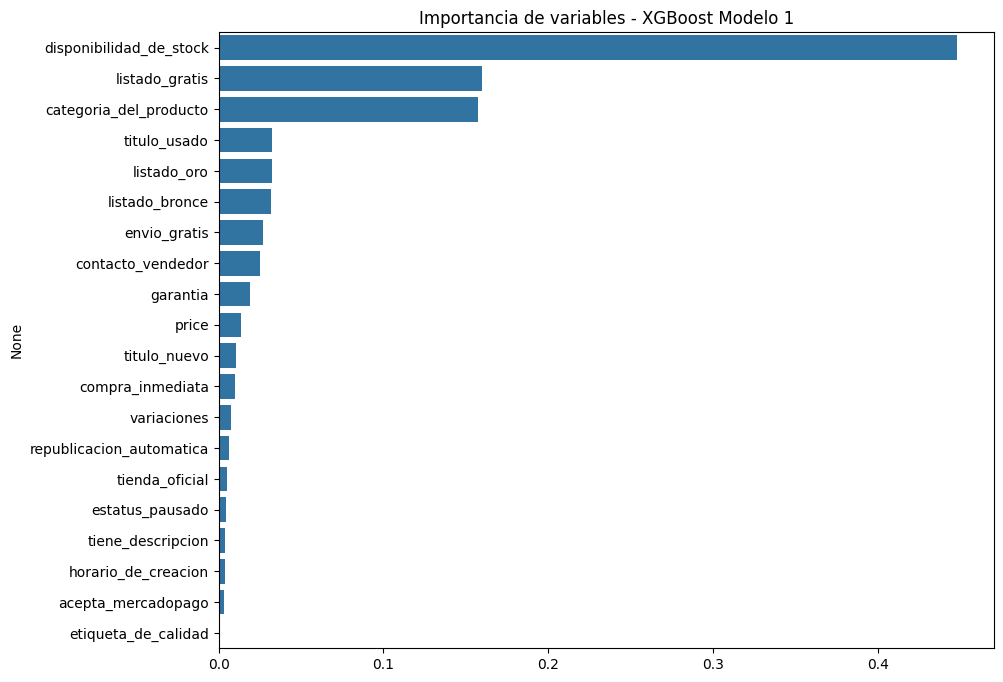

In [72]:
importances = best_model_xgb.feature_importances_
features = X_train.columns
sorted_idx = importances.argsort()[::-1]

plt.figure(figsize=(10, 8))
sns.barplot(x=importances[sorted_idx], y=features[sorted_idx])
plt.title("Importancia de variables - XGBoost Modelo 1")
plt.show()


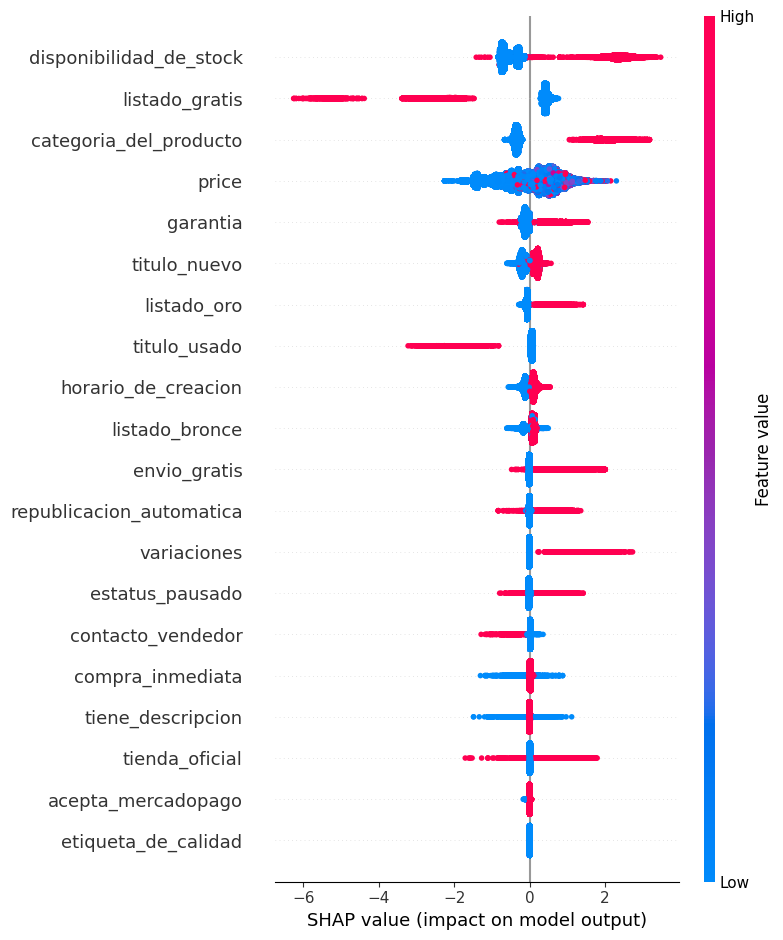

In [73]:
import shap

explainer = shap.TreeExplainer(best_model_xgb)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)


# Análisis de Importancia de Variables

## Variables más importantes

Las siguientes variables tienen alta relevancia tanto en ganancia como en los valores SHAP:

| Variable                  | Interpretación                                                                 |
|---------------------------|-------------------------------------------------------------------------------|
| `disponibilidad_de_stock` | Es la variable más influyente. Cuando en el stock hay más de un producto hay alta proba de que sea nuevo. |
| `listado_gratis`          | Tiene fuerte peso y alto impacto SHAP. Cuando esta en listado free es altamente probable que el producto no sea nuevo. |
| `categoria_del_producto`  | Alta relevancia, probablemente debido a que algunas categorías estan asociadas hacia productos nuevos. |

---

## Variables con baja relevancia (candidatas a eliminar)

Estas variables muestran baja o nula contribución al modelo:

| Variable                | Justificación                                                   |
|-------------------------|------------------------------------------------------------------|
| `etiqueta_de_calidad`   | No aporta ni ganancia ni impacto explicativo.                   |
| `acepta_mercadopago`    | Mínima influencia en ambas gráficas.                            |
| `tienda_oficial`        | Relevancia cercana a cero.                                      |
| `tiene_descripcion`     | No se observa diferencia clara en el output del modelo.         |
| `estatus_pausado`       | Sin aporte significativo.                                       |
| `variaciones`           | Bajo impacto; podría ser redundante.                            |

---

## Variables de impacto intermedio

Estas variables no lideran la importancia pero sí aportan valor explicativo:

| Variable           | Comentario                                                |
|--------------------|-----------------------------------------------------------|
| `garantia`         | Su impacto es moderado en SHAP, relevante para interpretabilidad. |
| `price`            | Valor útil, especialmente en combinación con otras variables.     |
| `titulo_usado` / `titulo_nuevo` | Extraídas del texto, ayudan a entender el contexto del producto. |


# Eliminación de variables

In [75]:
# eleiminar variables que no aportan
train_v2 = train.drop(['etiqueta_de_calidad',
                       'acepta_mercadopago',
                       'tienda_oficial',
                       'tiene_descripcion',
                       'estatus_pausado',
                       'variaciones'
                       ], axis=1)

test_v2 = test.drop(['etiqueta_de_calidad',
                       'acepta_mercadopago',
                       'tienda_oficial',
                       'tiene_descripcion',
                       'estatus_pausado',
                       'variaciones'
                       ], axis=1)

In [77]:

X_train_v2 = train_v2.drop(columns=['condition'])
y_train_v2 = train_v2['condition']

X_test_v2 = test_v2.drop(columns=['condition'])
y_test_v2 = test_v2['condition']

# ------------------------------
# Modelo base y búsqueda
# ------------------------------
xgb_model_v2 = XGBClassifier(
    eval_metric='logloss',
    colsample_bytree=0.8,
    learning_rate=0.12,
    max_depth=5,
    n_estimators=300,
    subsample=0.7,
    random_state=42
)

xgb_model_v2.fit(X_train_v2, y_train_v2)
y_pred_proba_xgb_v2 = xgb_model_v2.predict_proba(X_test_v2)[:, 1]
y_pred_label_xgb_v2 = xgb_model_v2.predict(X_test_v2)  

# Predicción final con umbral óptimo
y_pred_opt_v2 = (y_pred_proba_xgb_v2 > 0.41).astype(int)

auc_test_v2 = roc_auc_score(y_test_v2, y_pred_opt_v2)
recall_test_v2 = recall_score(y_test_v2, y_pred_opt_v2)
precision_test_v2 = precision_score(y_test_v2, y_pred_opt_v2)
f1_test_v2 = f1_score(y_test_v2, y_pred_opt_v2)


print(f"AUC ROC en test: {auc_test_v2:.4f}")
print(f"Recall en test: {recall_test_v2:.4f}")
print(f"Precision en test: {precision_test_v2:.4f}")
print(f"F1-score en test: {f1_test_v2:.4f}")

AUC ROC en test: 0.8511
Recall en test: 0.8690
Precision en test: 0.8598
F1-score en test: 0.8644


## Conclusiones tras eliminar variables con baja importancia

Se eliminaron 6 variables del conjunto de entrenamiento que presentaban una baja contribución:

- `etiqueta_de_calidad`  
- `acepta_mercadopago`  
- `tienda_oficial`  
- `tiene_descripcion`  
- `estatus_pausado`  
- `variaciones`

---

### Resultados de métricas antes y después

| Métrica       | Antes     | Después   | Variación |
|---------------|-----------|-----------|-----------|
| AUC ROC       | 0.8530    | 0.8511    | -0.0019   |
| Recall        | 0.8774    | 0.8690    | -0.0084   |
| Precisión     | 0.8577    | 0.8598    | +0.0021   |
| F1-score      | 0.8674    | 0.8644    | -0.0030   |

---

### Conclusiones

- Las métricas del modelo se mantuvieron prácticamente **sin cambios** después de eliminar estas 6 variables, lo que **confirma que su contribución al desempeño era marginal o nula**.
- Esta simplificación **mejora la interpretabilidad** y reduce el riesgo de sobreajuste al eliminar ruido innecesario.

---

### Recomendación

Continuar con esta versión optimizada del modelo, ya que se logra un equilibrio entre rendimiento y simplicidad.


# Guardado del modelo

In [78]:
# Guardar modelo
import joblib
joblib.dump(xgb_model_v2, '../models/modelo_xgb_v2.pkl')

['../models/modelo_xgb_v2.pkl']

In [79]:
X_test_v2.to_csv('../data/X_test_v2.csv', index=False)
y_test_v2.to_csv('../data/y_test_v2.csv', index=False)

# Comentarios adicionales

También probé modelos con el algoritmo **Random Forest**. Mi idea era realizar un ensamble con el modelo **XGBoost**, pero al momento de hacerlo realmente no obtuve ninguna ganancia. Por ello, para no hacer más compleja la estructura de predicción, decidí quedarme únicamente con el modelo **XGBoost**, como expliqué en la parte de arriba.
